### 【問題1】重みの初期値を決めるコードの作成
### 【問題2】フォワードプロパゲーションの実装
### 【問題3】交差エントロピー誤差の実装
### 【問題4】バックプロパゲーションの実装
### 【問題5】推定

In [92]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchSimpleNeuralNetworkClassifier:
    def __init__(self):
        self.learning_rate = 0.01 # 学習率
        self.n_features = 784     # 特徴量の数
        self.n_nodes1 = 400       # 1層目のノード数
        self.n_nodes2 = 200       # 2層目のノード数
        self.n_output = 10        # 出力のクラス数（3層目のノード数）(yの種類数=クラス数)
        self.sigma = 0.02         # 重み、ガウス分布の標準偏差、ハイパーパラメータ
        self.batch_size = 20      # ミニバッチ分割の分割数
        self.epoch = 10           # 繰り返し回数

    def fit(self, x, y):
        # weight:線 平均0、分散1（標準偏差1）の正規分布に従う乱数を指定のshapeで生成
        self.w1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.w2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.w3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        # bias
        self.b1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.b2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.b3 = self.sigma * np.random.randn(1, self.n_output)
        # todo
        self.loss_train = []
        # self.loss_test = []

        for _ in range(self.epoch):
            # ミニバッチ
            get_mini_batch = GetMiniBatch(x, y, batch_size=self.batch_size)
            for mini_x_train, mini_y_train in get_mini_batch:
                self.forward_propagation(mini_x_train)
                self.back_propagation(mini_x_train, mini_y_train)
            # 評価値を出すために最後のフォワードプロパゲーション
            self.forward_propagation(x)
            self.loss_train.append(self.categorical_crossentropy(y, self.z3))

    def forward_propagation(self, x):
        # 1層目
        self.a1 = x @ self.w1 + self.b1  # A1 = X・W + B (numpy.dot = ベクトルの内積)
        self.z1 = self.tanh(self.a1)          # Z1 = f(A)
        # 2層目
        self.a2 = self.z1 @ self.w2 + self.b2 # A2 = X1・W2 + B2
        self.z2 = self.tanh(self.a2)          # Z2 = f(A2)
        # 3層目
        self.a3 = self.z2 @ self.w3 + self.b3 # A3 = Z2・W3 + B3 // W3が10列なのでここで10列になっている
        self.z3 = self.softmax(self.a3)       # Z3 = softmax(A3)

    def back_propagation(self, x, y):
        # 3層目
        dA3 = self.z3 - y     # nで割るの忘れてる？
        dB3 = np.sum(dA3, axis=0)
        dW3 = self.z2.T @ dA3
        # 2層目
        dZ2 = dA3 @ self.w3.T
        dA2 = dZ2 * (1 - self.tanh(self.a2)**2)
        dB2 = np.sum(dA2, axis=0)
        dW2 = self.z1.T @ dA2
        # 1層目
        dZ1 = dA2 @ self.w2.T
        dA1 = dZ1 * (1 - self.tanh(self.a1)**2)
        dB1 = np.sum(dA1, axis=0)
        dW1 = x.T @ dA1

        # マイナスで良いのか？
        self.w3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * dB3

        self.w2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * dB2

        self.w1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * dB1

    # @staticmethod
    # def sigmoid(x):
    #     return 1 / (1 + np.exp(-x)) # eのx乗を返す e = ネイピア数 2.718281..

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def softmax(a):
        exp_a = np.exp(a) # eのx乗を返す
        sum_exp_a = np.sum(np.exp(a), axis=1).reshape(-1, 1) # 指数関数の和
        return exp_a / sum_exp_a

    # 多クラス交差エントロピー
    # y: ニューラルネットワークの出力
    # t: 教師データ
    @staticmethod
    def categorical_crossentropy(y, t):
        return - ( np.sum(y * np.log(t + 1e-7)) / len(y) )

    def predict(self, x):
        self.forward_propagation(x)
        return np.argmax(self.z3, axis=1)

In [105]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from IPython.display import display

#
# データセット準備
#

(x_train, y_train), (x_test, y_test) = mnist.load_data() # shape(60000, 28, 28)
print(x_train.shape) # (60000, 28, 28)

#
# 前処理
#

# 平滑化
x_train = x_train.reshape(-1, 784) # shape(60000, 784)
x_test = x_test.reshape(-1, 784)   # shape(60000, 784)
# スケール調整
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
print(x_train.max())
print(x_train.min())
# 分割
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)
print(x_train.shape) # (48000, 784)
print(x_valid.shape) # (12000, 784)
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 学習
model = ScratchSimpleNeuralNetworkClassifier()
model.fit(x_train, y_train_one_hot)

(60000, 28, 28)
1.0
0.0
(48000, 784)
(12000, 784)


[0.18896010504771096,
 0.10653434154768146,
 0.0731246542082015,
 0.053710214418475136,
 0.04248515547112884,
 0.034473767079088245,
 0.027829075144917254,
 0.023472412859403463,
 0.019458049729272543,
 0.011665487461131042]

0.9752

### 【問題6】学習と推定

In [106]:
# 学習結果
display(model.loss_train)
# 予測
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# 評価
from sklearn.metrics import accuracy_score
display(accuracy_score(y_train, pred_train))
display(accuracy_score(y_test, pred_test))


[0.18896010504771096,
 0.10653434154768146,
 0.0731246542082015,
 0.053710214418475136,
 0.04248515547112884,
 0.034473767079088245,
 0.027829075144917254,
 0.023472412859403463,
 0.019458049729272543,
 0.011665487461131042]

0.996625

0.9752

### 【問題7】学習曲線のプロット

No handles with labels found to put in legend.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


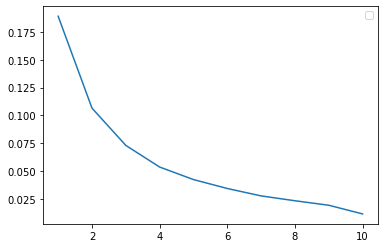

In [113]:
import matplotlib.pyplot as plt

plot_x = [i for i in range(1, model.epoch+1)]
plt.plot(plot_x, model.loss_train)
plt.legend()
plt.show()

memo:
https://rightcode.co.jp/blog/information-technology/back-propagation-algorithm-implementation